# Regresie Logistică

Tudor Berariu - 2018

Alexandru Sorici - 2024

In [293]:
%pip install numpy
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [294]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## 1. Scopul Laboratorului

Scopul laboratorului îl reprezintă înțelegerea algoritmului de **regresie logistică** și a rezolvării unei probleme de clasificare prin aplicarea principiului de **estimare a verosimilității maxime (eng. Maximum Likelihood Estimation)**.
De asemenea, vom aplica **metoda scăderii gradientului (eng. gradient descent)** pentru a rezolva o problemă de minimizare.

Regresia logistică este aplicabilă atunci când dorim să rezolvăm o problemă de **clasificare** (în mod standard **binară**, dar metoda poate fi extinsă și pentru caz multinomial). 

Variabilele folosite în predicție (peste care se aplică regresia) pot fi:
  - variabile continue (date numerice)
  - variabile discrete nominale, i.e. date care provin din niște categorii cu un domeniu de valori finit (e.g. culoarea parului, zilele saptamanii)
  - variabile discrete ordinale, i.e. date care suportă o relație de ordine (e.g. numarul de stelute la o recenzie de produs)
  
 **Ipoteza de învățare** este că variabilele de predicție se află într-o relație **liniară** cu "**log odds**" al varibilei dependente (cea pe care dorim să o clasificăm binar).
 

$$p = P(y=1 \vert {\bf x}; {\bf \theta})$$
$$l = ln(\frac{p}{1-p}) = w_0 + w_1 x_1 + \cdots + w_n x_n $$

Rezultă că **probabilitatea** $p$, ca un exemplu să facă parte din clasa "pozitivă" este modelată cu ajutorul funcției logistice $\sigma(a) = \frac{1}{1+e^{-a}}$ 

$$p = \frac{1}{1+ e^{-(w_0 + w_1 x_1 + \cdots + w_n x_n)}}$$

![sigmoid function](res/sigmoid.png)

## 2. Maximum Likelihood Estimation (MLE) pentru Regresie Logistică 

Se dă setul de date (**X**, **t**) constând dintr-o mulțime **X** de N eșantioane de dimensiune D (i.e. fiecare ${\bf x^{(i)}} \in {\bf X}$ este de forma ${\bf x} = (x_1, x_2, ..., x_D)$) (fiecare eșantion are D atribute).
Pentru fiecare ${\bf x}^{(n)} \in X$ exista un $t^{(n)} \in {0, 1}$, reprezentând **clasa** din care face parte exemplul ${\bf x}^{(n)}$.

Predictia data de regresia logistică pentru $x^{(n)}$ este $y^{(n)} = \sigma({\bf w^T x^{(n)}} )$

Astfel, rezulta setul de date $\{{\bf X}, {\bf t}\}$ pentru care vom formula expresia de Maximum Likelihood al datelor ca:

$$p({\bf t} \vert {\bf w}) = \prod_{n=1}^{N}{y^{(n)}}^{t^{(n)}}(1 - y^{(n)})^{1-t^{(n)}}$$

Pentru stabilitate numerica, in loc de **maximizarea** MLE-ului, vom logaritma expresia si vom **minimiza** media pentru **negative log likelihood (NLL)**.

$$J({\bf w}) = -\frac{1}{N} ln(p({\bf t} \vert {\bf w})) = - \frac{1}{N} \sum_{n=1}^{N} \left[t^{(n)}ln(y^{(n)}) + (1-t^{(n)})ln(1 - y^{(n)})\right]$$

## 3. Minimizarea folosind metoda scăderii gradientului

Algoritmul de minimizare a unei functii obiectiv $J({\bf w})$ folosind scaderea gradientului are forma urmatoare:

<!-- ![gradient descent](img/alg-gradient-descent.png) -->
**Procedura Scăderii Gradientului**
  - intrări: 
    - ${\bf w}_{init}$ - ponderi inițializate aleator dintr-o distribuție normala $N(\mu=0, \Sigma=I)$ 
    - $\alpha$ (rata de învățare)
    - nr\_epoci - numărul de epoci de antrenare
  - ieșiri:
    - ${\bf w^*}$ - ponderi care minimizează funcția de eroare $J({\bf w})$ 

1. ${\bf w_0}$ = ${\bf w}_{init}$
2. $t$ = 1
3. **cât timp** $t$ < nr\_epoci:
4. &nbsp;&nbsp;&nbsp;&nbsp; ${\bf w}_t \leftarrow {\bf w}_{t-1} - \alpha \nabla_{\bf w} J({\bf w})$
5. &nbsp;&nbsp;&nbsp;&nbsp; $t \leftarrow t+1 $ 


unde gradientul functiei $J({\bf w})$ este:
    
$$\nabla_{\bf w} J({\bf w}) = \frac{1}{N}\sum_{n=1}^{N} (y^{(n)} - t^{(n)}) {\bf x}^{(n)} = \frac{1}{N} {\bf X^T} \cdot ({\bf y - t})$$

în care operația $\cdot$ este înmulțire punct-cu-punct (`numpy.dot`), iar $\alpha$ este **rata de invățare** care controlează "lungimea" pasului în direcția opusă gradientului.

## 4. Setul de date

In [295]:
def two_clusters(N, variance=0.1):
    N1 = N // 2
    N2 = N - N1
    X1 = np.random.randn(N1, 2) * variance + 0.25
    X2 = np.random.randn(N2, 2) * variance + 0.75
    X = np.concatenate([X1, X2], axis=0)
    T = np.concatenate([np.zeros((N1)), np.ones((N2))], axis=0)
    p = np.random.permutation(N)
    return X[p], T[p]

In [296]:
def visualize_dataset(X, T, Y=None, w=None, other_w=None):
    m = ["x", "o"]  # Indicates true class
    col = ["red", "blue"]  # Indicates prediction
    fig = plt.figure(); plt.axis('equal')
    if Y is not None:
        idx_tp = np.logical_and(T >= .5, Y >= .5) # True positives
        idx_fp = np.logical_and(T < .5, Y >= .5) # False positives
        idx_fn = np.logical_and(T >= .5, Y < .5) # False negatives
        idx_tn = np.logical_and(T < .5, Y < .5) # True negatives
        
        plt.scatter(X[idx_tp,0], X[idx_tp,1], marker=m[0], c="red", label="TP")
        plt.scatter(X[idx_fp,0], X[idx_fp,1], marker=m[1], c="red", label="FP")
        plt.scatter(X[idx_fn,0], X[idx_fn,1], marker=m[0], c="blue", label="FN")
        plt.scatter(X[idx_tn,0], X[idx_tn,1], marker=m[1], c="blue", label="TN")

    else:
        idx_pos, idx_neg = (T > .5), (T < .5)
        plt.scatter(X[idx_pos,0], X[idx_pos,1], marker=m[0], color="blue", label="Pos")
        plt.scatter(X[idx_neg,0], X[idx_neg,1], marker=m[1], color="blue", label="Neg")
    
    if w is not None:
        __x = np.linspace(0, 1, 100)
        __y = -w[0] / w[1] * __x - w[2] / w[1]
        plt.plot(__x, __y, color="black")

    if other_w is not None:
        __x = np.linspace(0, 1, 100)
        __y = -other_w[0] / other_w[1] * __x - other_w[2] / other_w[1]
        plt.plot(__x, __y, color="orange")

    plt.xlabel("x"); plt.ylabel("y")
    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    plt.show()

In [297]:
def split_dataset(X, T, train=.8):
    N = X.shape[0]
    N_train = int(round(N * train))
    N_test = N - N_train

    X_train, X_test = X[:N_train,:], X[N_train:,:]
    T_train, T_test = T[:N_train], T[N_train:]
    return X_train, T_train, X_test, T_test


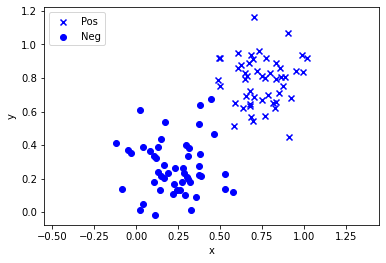

In [298]:
X, T = two_clusters(100, variance=0.15)
visualize_dataset(X, T, Y=None)

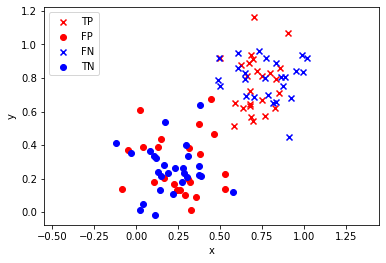

In [299]:
visualize_dataset(X, T, Y=np.random.uniform(size=T.size))

### Setul de date extins

Dorim sa testam robustetea regresiei logistice la adaugarea unor exemple extreme din clasa pozitivă.

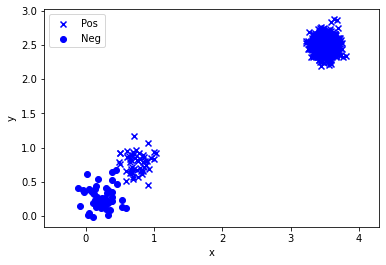

In [300]:
extra_N = 800
extra_X = np.random.randn(extra_N, 2) * 0.1
extra_X[:,1] += 2.5
extra_X[:,0] += 3.5
extra_T = np.ones(extra_N)
X_extended = np.concatenate([X, extra_X], axis=0)
T_extended = np.concatenate([T, extra_T], axis=0)

visualize_dataset(X_extended, T_extended, Y=None)

## 5.1 - Cerinta 1: Implementarea functiei de sigmoida logistica

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$


In [301]:
# TODO <1>: Implementati functia de sigmoida logistica
def logistic(x):
    # TODO: Inlocuiti aici cu expresia functiei de sigmoida logistica
    # Atentie: x poate fi un vector numpy, deci operatiile trebuie facute pe vectori
    # return np.zeros_like(x)  
    return 1 / (1 + np.exp(-x))

Logistic looks ok


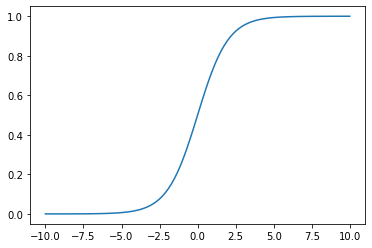

In [302]:
# Test for the logistic function
x = np.linspace(-10, 10, 100)
expected_output = np.array(
  [4.53978687e-05, 5.55606489e-05, 6.79983174e-05, 8.32200197e-05,
 1.01848815e-04, 1.24647146e-04, 1.52547986e-04, 1.86692945e-04,
 2.28478855e-04, 2.79614739e-04, 3.42191434e-04, 4.18766684e-04,
 5.12469082e-04, 6.27124987e-04, 7.67413430e-04, 9.39055039e-04,
 1.14904229e-03, 1.40591988e-03, 1.72012560e-03, 2.10440443e-03,
 2.57431039e-03, 3.14881358e-03, 3.85103236e-03, 4.70911357e-03,
 5.75728612e-03, 7.03711536e-03, 8.59898661e-03, 1.05038445e-02,
 1.28252101e-02, 1.56514861e-02, 1.90885420e-02, 2.32625358e-02,
 2.83228820e-02, 3.44451957e-02, 4.18339400e-02, 5.07243606e-02,
 6.13831074e-02, 7.41067363e-02, 8.92170603e-02, 1.07052146e-01,
 1.27951705e-01, 1.52235823e-01, 1.80176593e-01, 2.11963334e-01,
 2.47663801e-01, 2.87185901e-01, 3.30246430e-01, 3.76354517e-01,
 4.24816868e-01, 4.74768924e-01, 5.25231076e-01, 5.75183132e-01,
 6.23645483e-01, 6.69753570e-01, 7.12814099e-01, 7.52336199e-01,
 7.88036666e-01, 8.19823407e-01, 8.47764177e-01, 8.72048295e-01,
 8.92947854e-01, 9.10782940e-01, 9.25893264e-01, 9.38616893e-01,
 9.49275639e-01, 9.58166060e-01, 9.65554804e-01, 9.71677118e-01,
 9.76737464e-01, 9.80911458e-01, 9.84348514e-01, 9.87174790e-01,
 9.89496155e-01, 9.91401013e-01, 9.92962885e-01, 9.94242714e-01,
 9.95290886e-01, 9.96148968e-01, 9.96851186e-01, 9.97425690e-01,
 9.97895596e-01, 9.98279874e-01, 9.98594080e-01, 9.98850958e-01,
 9.99060945e-01, 9.99232587e-01, 9.99372875e-01, 9.99487531e-01,
 9.99581233e-01, 9.99657809e-01, 9.99720385e-01, 9.99771521e-01,
 9.99813307e-01, 9.99847452e-01, 9.99875353e-01, 9.99898151e-01,
 9.99916780e-01, 9.99932002e-01, 9.99944439e-01, 9.99954602e-01])
output = logistic(x)
assert np.allclose(output, expected_output), "Logistic function does not match expected values"
print("Logistic looks ok")

plt.figure()
plt.plot(x, output)
plt.show()

## 5.2 - Cerinta 2: Definirea funcției de eroare și a metricii de performanță
Funcția de eroare ce trebuie minimizată în regresia logistică este **Negative Log Likelihood**:


$$J({\bf w}) = -\frac{1}{N} ln(p({\bf t} \vert {\bf w})) = - \frac{1}{N} \sum_{n=1}^{N} \left[t^{(n)}ln(y^{(n)}) + (1-t^{(n)})ln(1 - y^{(n)})\right]$$

In [303]:
# TODO <2.1>: Implementati expresia pentru Negative Log Likelihood - functia J(w), unde Y este predictia data de modelul logistic, 
# iar T sunt etichetele de clasa pentru cele N exemple din setul de date
def nll(Y, T):
    N = T.shape[0]

    # TODO: Inlocuiti aici cu expresia functiei de Negative Log Likelihood
    # Hint: folositi notiunea de indexare logica din numpy si faptul ca T poate fi 0 sau 1
    nll_exp = -1/N * np.sum(T * np.log(Y) + (1 - T) * np.log(1 - Y))
    return nll_exp

In [304]:
# Test the nll function
predictions = np.array([0.8, 0.2, 0.6, 0.4, 0.9, 0.3, 0.7, 0.1, 0.5, 0.8])
targets = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

# Calculate NLL
nll_value = nll(predictions, targets)

# Check if the value is correct
if np.isclose(nll_value, 0.4694594362347564):
    print("NLL looks ok")
else:
    print("NLL is incorrect")


NLL looks ok


**Metrica de performanță** este **acuratețea**, care întoarce **o medie** a exemplelor din setul de date clasificate corect.

$$ acc = \frac{1}{N} \sum_{i=1}^N eval(y^{(i)}, t^{(i)}) $$

Unde $eval(y^{(i)}, t^{(i)})$ întoarce `1` dacă:
  - pentru $t^{(n)}$ = 1, $y^{(n)} \geq 0.5$
  - pentru $t^{(n)}$ = 0, $y^{(n)} \lt 0.5$

și `0` altfel.

In [305]:
# TODO <2.2>: Implementati expresia care intoarce acuratetea clasificarii
def accuracy(Y, T):
    N = Y.shape[0]

    # TODO: Inlocuiti aici cu expresia functiei de acuratete
    # Hint: folositi notiunea de indexare logica din numpy si faptul ca 
    #       in numpy True este echivalent cu 1 si False cu 0
    correct_predictions = np.sum((Y >= 0.5) == T)
    accuracy = correct_predictions / N
    return accuracy

In [306]:
# Test the accuracy function
predictions = np.array([0.2, 0.8, 0.6, 0.4, 0.4, 0.3, 0.7, 0.1, 0.6, 0.2])
target = np.array([0, 1, 1, 0, 1, 0, 1, 0, 1, 1])

expected_accuracy = 0.8
computed_accuracy = accuracy(predictions, target)

if np.isclose(computed_accuracy, expected_accuracy):
    print("Accuracy looks ok")
else:
    print("Accuracy is incorrect")


Accuracy looks ok


## 5.3 - Cerința 3 - Antrenarea modelului logistic și utilizarea modelului (predicția)
Predicția unui model logistic este dată de aplicarea funcției de **sigmoidă logistică** peste produsul scalar al fiecărui exemplu ${\bf x}^{(i)}$ cu ponderile ${\bf w}$. 

$$y^{(i)} = logistic({\bf x}^{(i)} \cdot {\bf w})$$

Funcția `predict_logistic` întoarce predicțiile ${\bf y}$ pentru toate exemplele din setul de date ${\bf X}$.

In [307]:
def predict_logistic(X, w):
    # TODO <3.1> : Calculati predictia Y a modelului logistic antrenat (ponderile w invatate)
    # Hint: urmariti explicatiile de utilizare ale functiei `numpy.dot` pentru a putea calcula 
    # produsele scalare intre toti vectorii x^(i) si ponderile w intr-un singur apel
    N = X.shape[0]
    N = logistic(np.dot(X, w))
    return N

In [308]:
# Test the predict_logistic function
X = np.array([[0.1, 0.2, 1], [0.2, 0.3, 1], [0.3, 0.4, 1], [0.4, 0.5, 1], [0.5, 0.6, 1],
              [0.6, 0.7, 1], [0.7, 0.8, 1], [0.8, 0.9, 1], [0.9, 1.0, 1], [1.0, 1.1, 1]])
w = np.array([0.1, 0.2, 0.3])

predictions = predict_logistic(X, w)

# check if the predictions are correct
expected_predictions = np.array([0.58661758, 0.5938731,  0.60108788, 0.60825903, 0.61538376, 0.62245933, 0.62948311, 0.63645254, 0.64336515, 0.65021855])
if np.allclose(predictions, expected_predictions):
    print("predict_logistic looks ok")
else:
    print("predict_logistic is incorrect")

predict_logistic looks ok


Antrenarea și evaluarea modelului de regresie logistică se face prin funcția `train_and eval_logistic`, care execută `epochs_nr` pași ai algoritmului de scădere a gradientului, returnând ponderile antrenare ${\bf w}$, precum și un istoric al erorii și al acurateții pe seturile de date de antrenare și de test.

Metoda de scădere a gradientului execută operațiile:
1. $t$ = 1
2. **cât timp** $t$ < nr\_epoci:
3. &nbsp;&nbsp;&nbsp;&nbsp; ${\bf w}_t \leftarrow {\bf w}_{t-1} - \alpha \nabla_{\bf w} J({\bf w})$
4. &nbsp;&nbsp;&nbsp;&nbsp; $t \leftarrow t+1 $ 

unde gradientul functiei $J({\bf w})$ este:
    
$$\nabla_{\bf w} J({\bf w}) = \frac{1}{N}\sum_{n=1}^{N} (y^{(n)} - t^{(n)}) {\bf x}^{(n)} = \frac{1}{N} {\bf X^T} \cdot ({\bf y - t})$$

In [309]:
def train_and_eval_logistic(X_train, T_train, X_test, T_test, lr=.01, epochs_no=100):
    # TODO <3.2> : Antrenati modelul logistic (ponderile W), executand epochs_no pasi din algoritmul de gradient descent
    (N, D) = X.shape

    # Initializare ponderi
    w = np.random.randn(D)
    
    train_acc, test_acc = [], []
    train_nll, test_nll = [], []

    for epoch in range(epochs_no):
        # 1. Obtineti Y_train si Y_test folosind functia predict_logistic
        Y_train = predict_logistic(X_train, w)
        Y_test = predict_logistic(X_test, w)

        # 2. Adaugati acuratetea si negative log likelihood-ul pentru setul de antrenare si de testare 
        #    la fiecare pas; utilizati functiile accuracy si nll definite anterior
        train_acc.append(accuracy(Y_train, T_train))
        test_acc.append(accuracy(Y_test, T_test))
        train_nll.append(nll(Y_train, T_train))
        test_nll.append(nll(Y_test, T_test))

        # 3. Actualizati ponderile w folosind regula de actualizare a gradientului
        grad = np.dot(X_train.T, (Y_train - T_train)) / N
        w -= lr * grad

    return w, train_nll, test_nll, train_acc, test_acc

## 6. Testarea pe setul de date Two Clusters

In [310]:
def plot_evolution(train_acc, test_acc, train_nll, test_nll):
    epochs_no = len(train_acc)
    fig, (ax1, ax2) = plt.subplots(2,1)

    # Afisam cu verde acuratetea pe setul de antrenare si cu rosu acuratetea pe setul de testare
    ax1.plot(range(epochs_no), train_acc, label="Train Accuracy", color="green")
    ax1.plot(range(epochs_no), test_acc, label="Test Accuracy", color="red")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='lower right', ncol=1)

    # Afisam cu verde NLL pe setul de antrenare si cu rosu NLL pe setul de testare
    ax2.plot(range(epochs_no), train_nll, label="Train NLL", color="green")
    ax2.plot(range(epochs_no), test_nll, label="Test NLL", color="red")
    ax2.set_xlabel("iteration")
    ax2.set_ylabel("NLL")
    ax2.legend(loc='upper right', ncol=1)
    
    plt.show()

Acuratete finala pe setul initial - train: 0.9625, test: 0.95


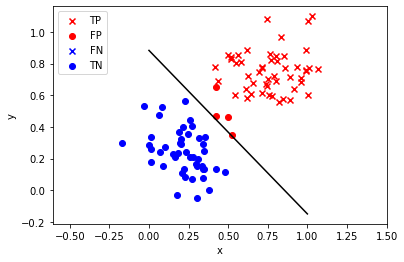

In [311]:
N_EPOCHS = 500  #@param {type: "slider", default: 500, min: 100, max: 1000}
N_POINTS = 100  #@param {type: "slider", default: 100, min: 50, max: 200}
VARIANCE = 0.15  #@param {type: "slider", default: 0.15, min: 0.0, max: 0.5}
X, T = two_clusters(N_POINTS, variance=VARIANCE)


# Adaugăm o coloană de 1-uri pentru bias in setul de date X
X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)

X_train, T_train, X_test, T_test = split_dataset(X, T, train=.8)

w, train_nll, test_nll, train_acc, test_acc = train_and_eval_logistic(X_train, T_train, X_test, T_test, lr=0.1, epochs_no=N_EPOCHS)

Y = predict_logistic(X, w)

print(f"Acuratete finala pe setul initial - train: {train_acc[-1]}, test: {test_acc[-1]}")

visualize_dataset(X, T, Y, w)

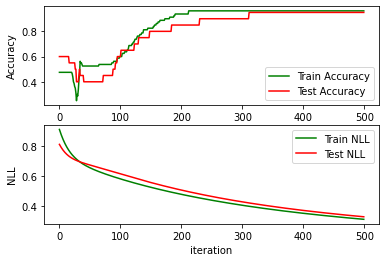

In [312]:
plot_evolution(train_acc, test_acc, train_nll, test_nll)

### 5.4 Testare pe setul de date Two Clusters Extins

In [313]:
extra_N = 800
extra_X = np.random.randn(extra_N, 2) * 0.1

# Adaugarea coordonatelor pentru termenul de bias
extra_X = np.concatenate([extra_X, np.ones((extra_N, 1))], axis=1)
extra_X[:,1] += 1.5
extra_X[:,0] += 3.5
extra_T = np.ones(extra_N)

# Adaugam datele noi la setul de date existent
X_extended = np.concatenate([X, extra_X], axis=0)
T_extended = np.concatenate([T, np.ones(extra_N)], axis=0)

# Le adaugam pe toate la setul de date de antrenare
X_train_extended = np.concatenate([X_train, extra_X], axis=0)
T_train_extended = np.concatenate([T_train, extra_T], axis=0)

Antrenăm și evaluăm regresia logistică pe **setul de date extins**. 

Graficul de vizualizare a rezultatului clasificării afișează cu o culoare portocalie dreapta de separație obținută după antrenarea pe setul de date **inițial**. 

Acuratete finala pe setul extins - train: 0.9977272727272727, test: 0.95


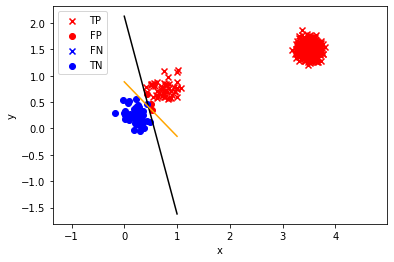

In [314]:
w_extended, train_nll_extended, test_nll_extended, train_acc_extended, test_acc_extended = train_and_eval_logistic(X_train_extended, T_train_extended, X_test, T_test, lr=0.1, epochs_no=N_EPOCHS)

Y_extended = predict_logistic(X_extended, w_extended)
print(f"Acuratete finala pe setul extins - train: {train_acc_extended[-1]}, test: {test_acc_extended[-1]}")
visualize_dataset(X_extended, T_extended, Y_extended, w=w_extended, other_w=w)

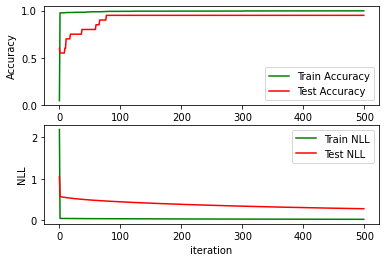

In [315]:
plot_evolution(train_acc_extended, test_acc_extended, train_nll_extended, test_nll_extended)

### 6. Analiză

1. Care este influența adăugăii punctelor pozitive extreme? Afectează ele rezultatul clasificării? Ce se observă în cazul rulării de mai multe ori a procesului de antrenare?
2. Putem folosi regresia liniară pentru a clasifica setul de date Two Clusters extins? Care ar fi rezultatul daca am face acest lucru?

1. Modificarea granitei de decizie => duc la modificarea performantei modelului.
In cazul rularii multiple putem observa o variatie a performantei modelului, deoarece punctele extreme pot influența aleatoriu rezultatul în fiecare rulare.

2. Poate duce la clasificari imprecise in cazul unor seturi de date cum ar fi "Two Clusters exitns". Daca am face acest lucru ar duce la clasificari eronate pentru punctele care nu se pot separa liniar.